### Clarifying notes
We were interested in two songs datasets from Kaggle: 1) a .csv file with Billboard Hot 100 data from every year since its conception, and 2) another .csv file with compositional attributes of every song ever to land on the Billboard. We found that "love" was one of the words most frequently used in the song titles, so we decided that we wanted to explore what variables were associated with "love" in a title. Our question of interest was:
*"What variables predict if a song will have love in its title?"*

NOTE TO READER: `Popularity Points Awarded` is a different metric than `spotify_track_popularity`. The former was something we calculated using a) the rank of a song on the Billboard Hot 100, and b) the length of time it was at a given position on the Billboard Hot 100. (This will be elaborated upon further in our paper.) `spotify_track_popularity` is a metric that Spotify calculates based on the number of plays a song has (source: https://developer.spotify.com/documentation/web-api/reference/get-an-artists-top-tracks). 

### Logistic Regression to determine variable importance
For our question, we decided that we wanted our output to be a prediction of the probability of a song having love in its title, and we represented this first using a logistic regression.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [3]:
#Read in datasets
spotify_data = pd.read_csv("../data/spotify_data.csv")

In [4]:
#Adding Has Love column
song_attribute_data = spotify_data

titles = song_attribute_data["Song"]
titles = titles.str.split(pat=" ", expand=True)

song_attribute_data["Has Word Love?"] = song_attribute_data['Song'].str.contains("Love")
song_attribute_data_love = song_attribute_data[song_attribute_data["Has Word Love?"]]

song_attribute_data = song_attribute_data.dropna()


In [5]:
#Prepare X and y
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["speechiness", "valence", "tempo", "time_signature", "Popularity Points Awarded"]]

def minmax(z):
    z = (z-min(z))/(max(z)-min(z))
    return z
X = X.apply(minmax,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'lbfgs',
                         max_iter=1000).fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))

Training R^2 0.9174862912350944
Test R^2 0.9136790810998956


We tried running regression without balancing "Has Love", but it kept returning the same R^2 reguardless of which variables we selected. Our target variable is highly imbalanced. Almost 92% of the songs do not have the word 'love' in the title, so our model has learned to always return an accuracy close to 1, which explains why the model always gives an accuracy close to .91 no matter what features or how many features we use.

Thus, below, we will add a new parameter called class_weight="balanced" to tell our model to care and focus more on the underrepresented population, which in this case is True: the title has the word 'love'.

In [6]:
print(song_attribute_data["Has Word Love?"].value_counts(normalize=True))


Has Word Love?
False    0.916725
True     0.083275
Name: proportion, dtype: float64


Let's see how the accuracy scores changed after adding this new parameter, class_weight="balanced", that tells the model to focus more on the underrepresented data.

In [7]:
#Prepare X and y
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["speechiness", "valence", "tempo", "time_signature", "Popularity Points Awarded"]]

X = X.apply(minmax,axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

#Run Regression
reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'lbfgs',
                         max_iter=1000,
                         class_weight='balanced').fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))
# We can see that the accuracy decreased

Training R^2 0.30785969187918877
Test R^2 0.3076923076923077


Without adjusting:

- Training R^2 0.9174862912350944
- Test R^2 0.9136790810998956

After adjusting:

- Training R^2 0.30785969187918877
- Test R^2 0.3076923076923077

We can see that the accuracy decreased.

In [8]:
#Run regression with all variables
X_n = song_attribute_data.iloc[:, [8] + [9] + list(range(11, 24))]
X_n = X_n.apply(minmax,axis=1)

dummies = pd.DataFrame([])
new_dummies = pd.get_dummies(song_attribute_data.loc[:,"spotify_track_explicit"], drop_first=True, dtype=int)
dummies = pd.concat([dummies, new_dummies], axis=1, ignore_index=True)

X2 = pd.concat([X_n,dummies],axis=1)
X2.columns = X2.columns.astype(str)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y, test_size=.2, random_state=100)

reg2 = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'lbfgs',
                         max_iter=1000,
                         class_weight='balanced'
                         ).fit(X2_train,y2_train)

print("Training R^2", reg2.score(X2_train, y2_train))
print("Test R^2", reg2.score(X2_test, y2_test))
features = pd.DataFrame(reg2.feature_names_in_, reg2.coef_[0])
features
#Return coefficients for each variable to see which are stronger predictors.

# (We were getting issues using the solver on different cpu's for everyone's...
# computers, so we changed the solver )


Training R^2 0.17703890678039863
Test R^2 0.18169161155586494


,0
4.476147e-02,spotify_track_duration_ms
1.013883e-04,spotify_track_explicit
1.042910e-04,danceability
1.023630e-04,energy
9.192698e-05,key
-4.061484e-08,loudness
1.107862e-04,mode
1.071439e-04,speechiness
1.194588e-04,acousticness
1.089231e-04,instrumentalness


In [9]:
#Try running regression with variables that had highest coefficients
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["spotify_track_duration_ms", "spotify_track_explicit", "danceability"]]

def minmax(z):
    z = (z-min(z))/(max(z)-min(z))
    return z
X = X.apply(minmax,axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

#Run Regression
reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'lbfgs',
                         max_iter=1000,
                         class_weight='balanced'
                         ).fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))
#Value is not very high, coefficients may not be best for finding significant variables

Training R^2 0.424405953520759
Test R^2 0.42046641141663765


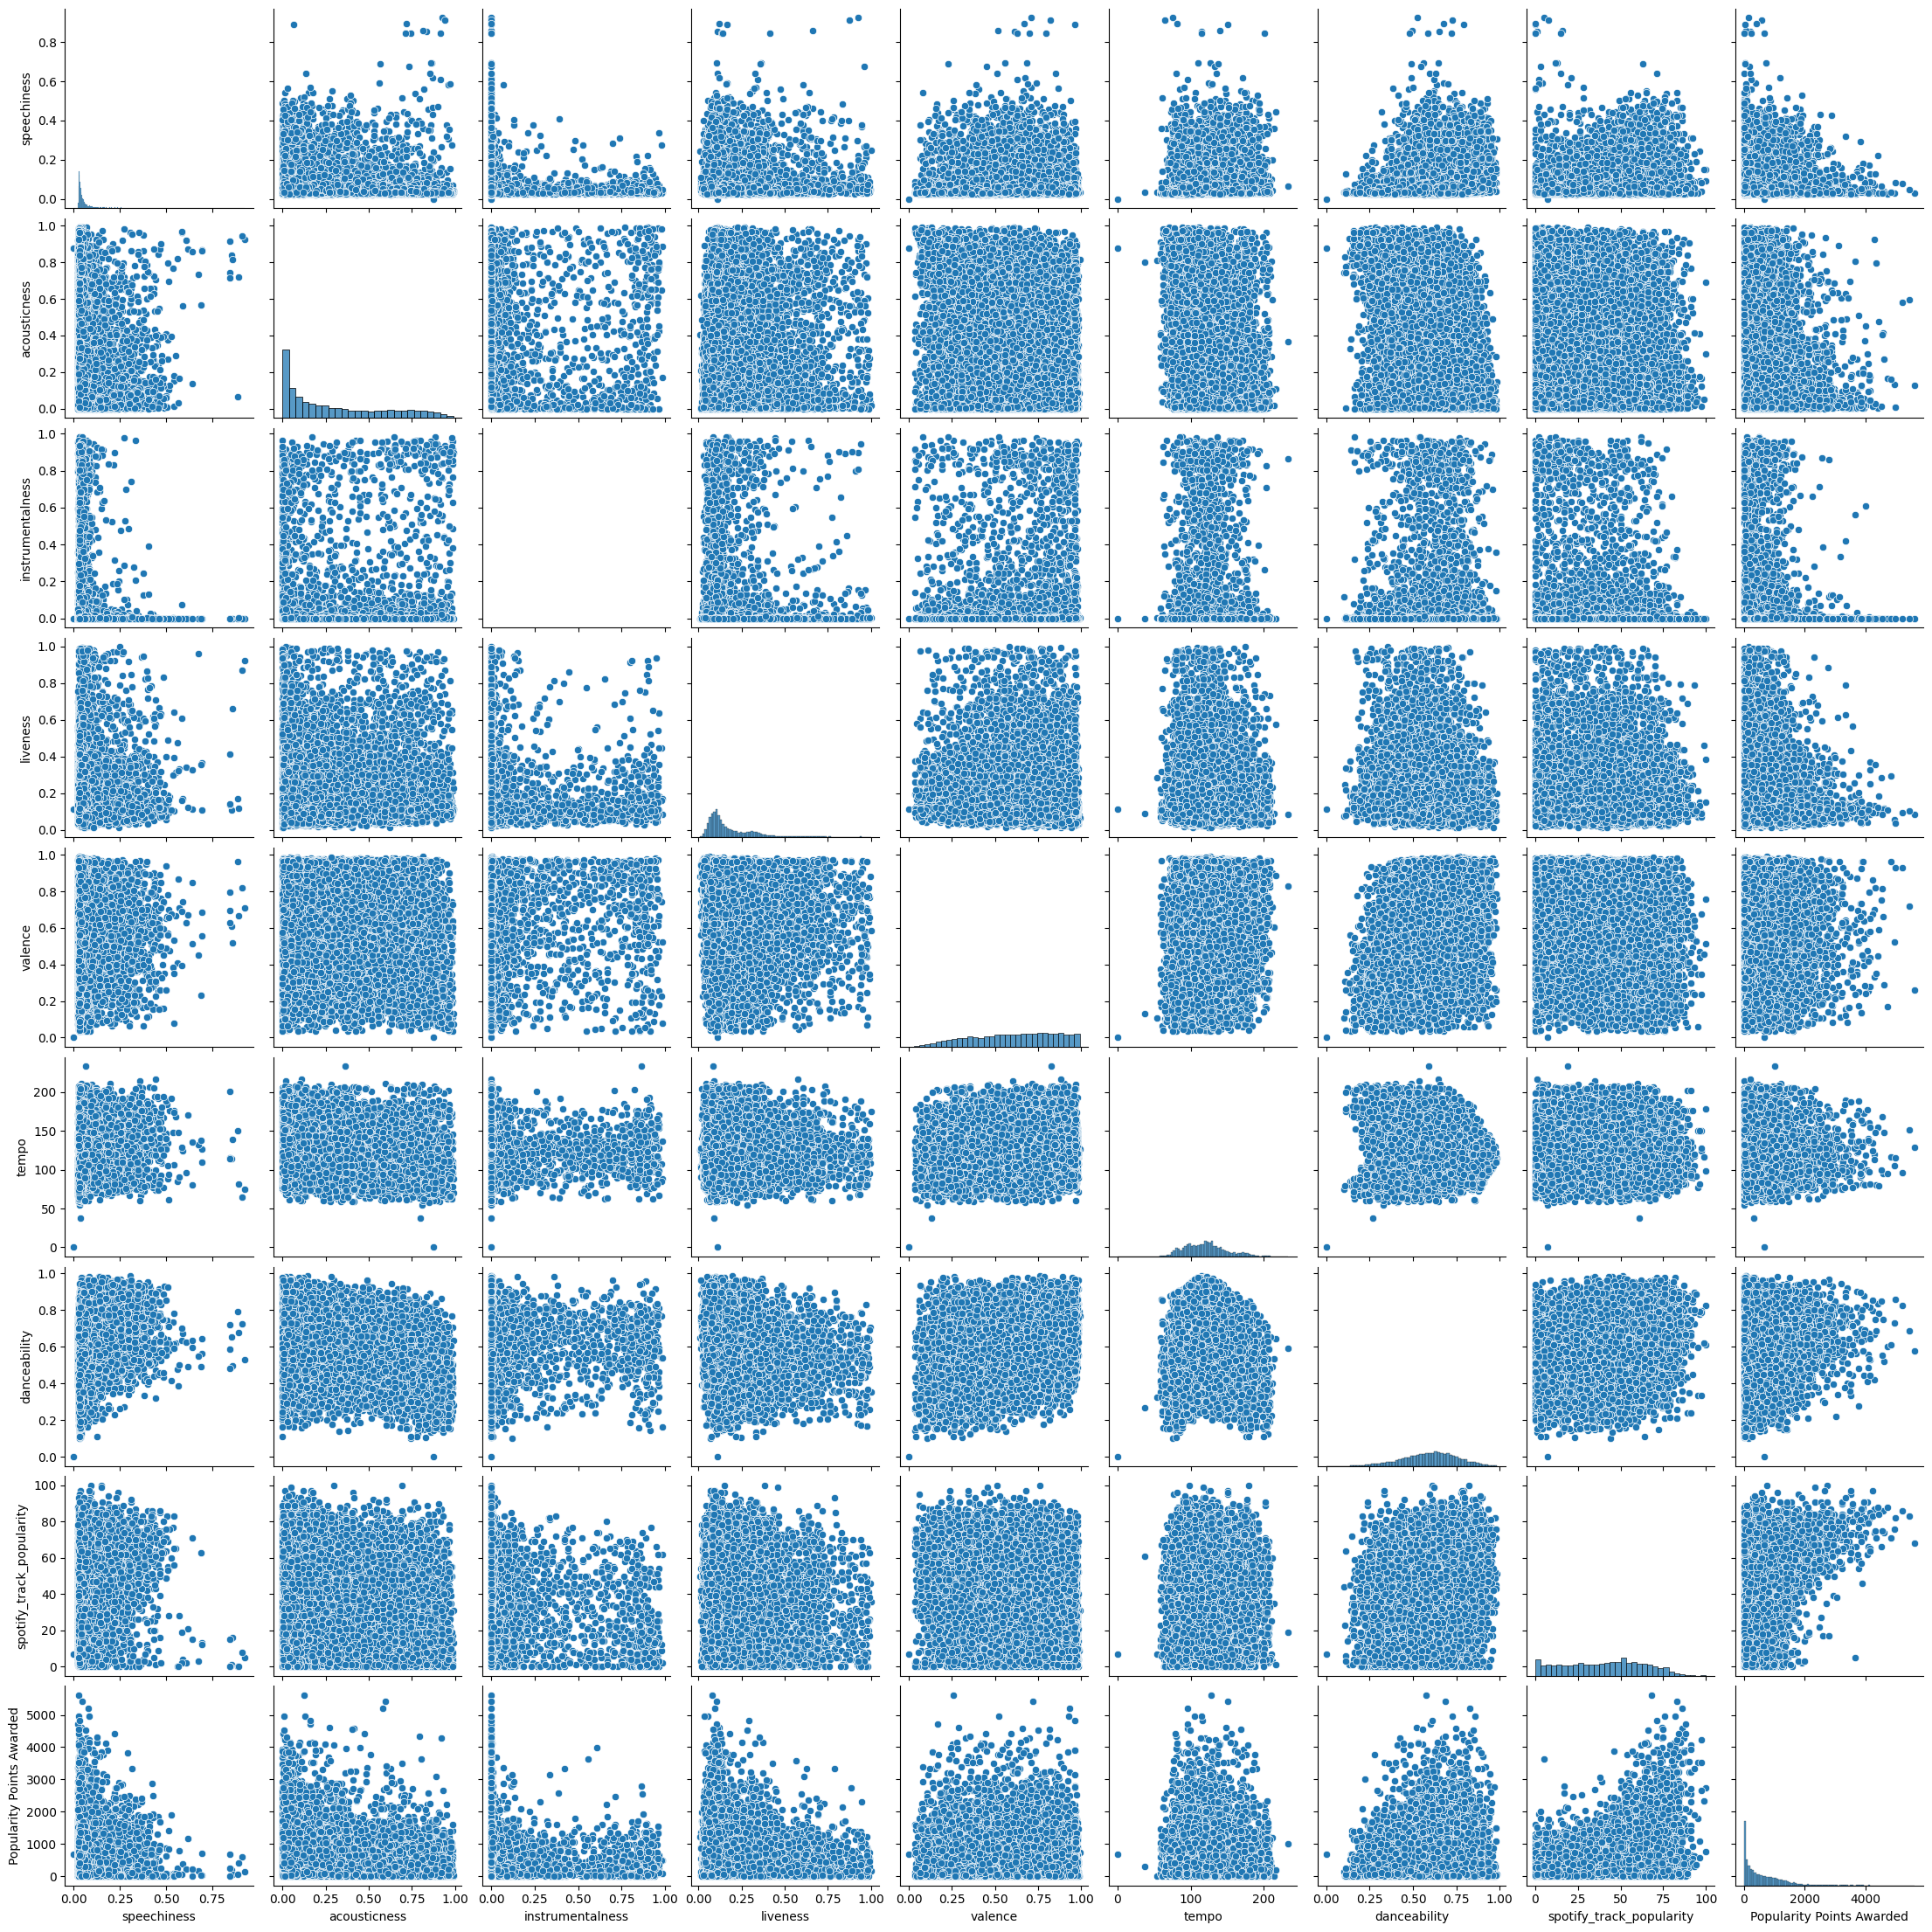

In [10]:
#Create pairplot to examine any potential relationships between variables
# We picked variables that we suspected would have relationships. 
X=song_attribute_data.loc[:,['speechiness', 'acousticness', 'instrumentalness',	'liveness',	'valence', 'tempo',	'danceability','spotify_track_popularity', 'Popularity Points Awarded']]
sns.pairplot(X)
# Many of the variables do not have discernable relationships with one another. 
# some of the variables do indeed have discernable relationships (for example...
# ...acousticness and speechiness), but the nature of the relationships is...
# ...difficult to discern. 

# Anything we are not able to capture with logistic regression, we hope we can...
# ...capture with our random forest (more on that later). 

We can see that the accuracy scores are worse when we use all the variables, and cherry-picking just a few features allowed us to account for a greater amount of variance. A model that used too many features resulted in multicolinearity/overfitting.

Let's try some more feature combinations using class_weight = 'balanced'

In [11]:
# Are songs that do better on the Billboard Hot 100 more likely to have...
# ...the word 'love'?
#Prepare X and y
y = song_attribute_data["Has Word Love?"]
X = song_attribute_data.loc[:,["Popularity Points Awarded"]]

def minmax(z):
    z = (z-min(z))/(max(z)-min(z))
    return z
X = X.apply(minmax,axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

#Run Regression
reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'lbfgs',
                         max_iter=1000,
                         class_weight='balanced'
                         ).fit(X_train,y_train)

print("Training R^2" , reg.score(X_train, y_train))
print("Test R^2", reg.score(X_test, y_test))

Training R^2 0.4016885716772565
Test R^2 0.40584754611903934


In [12]:
song_attribute_data.head()

,Unnamed: 0,index,SongID,Performer,Song,spotify_genre,spotify_track_id,spotify_track_preview_url,spotify_track_duration_ms,spotify_track_explicit,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,Popularity Points Awarded,Has Word Love?
2,2,2,......And Roses And RosesAndy Williams,Andy Williams,......And Roses And Roses,"['adult standards', 'brill building pop', 'eas...",3tvqPPpXyIgKrm4PR9HCf0,https://p.scdn.co/mp3-preview/cef4883cfd1e0e53...,166106.0,False,...,0.0315,0.9110,0.000267,0.1120,0.150,83.969,4.0,38.0,362.0,False
4,4,4,...Baby One More TimeBritney Spears,Britney Spears,...Baby One More Time,"['dance pop', 'pop', 'post-teen pop']",3MjUtNVVq3C8Fn0MP3zhXa,https://p.scdn.co/mp3-preview/da2134a161f1cb34...,211066.0,False,...,0.0307,0.2020,0.000131,0.4430,0.907,92.960,4.0,77.0,2727.0,False
7,7,7,'65 Love AffairPaul Davis,Paul Davis,'65 Love Affair,"['album rock', 'bubblegum pop', 'country rock'...",5nBp8F6tekSrnFg8G2Pvug,https://p.scdn.co/mp3-preview/a701445830ecacfb...,219813.0,False,...,0.0274,0.4320,0.000006,0.1330,0.952,155.697,4.0,40.0,1300.0,True
10,10,10,'til I Can Make It On My OwnTammy Wynette,Tammy Wynette,'til I Can Make It On My Own,"['country', 'country dawn', 'nashville sound']",0aJHZYjwbfTmeyUWF7zGxI,https://p.scdn.co/mp3-preview/73a24c43d2b48dc5...,182080.0,False,...,0.0318,0.8320,0.000035,0.1080,0.146,141.148,4.0,31.0,43.0,False
12,12,12,'Til My Baby Comes HomeLuther Vandross,Luther Vandross,'Til My Baby Comes Home,"['funk', 'motown', 'neo soul', 'new jack swing...",2R97RZWUx4vAFbMMtmb5Ss,https://p.scdn.co/mp3-preview/c54184ec2fc7e8bd...,332226.0,False,...,0.1830,0.0567,0.000006,0.0253,0.802,139.663,4.0,29.0,721.0,False


In [13]:
song_attribute_data.describe()

,Unnamed: 0,index,spotify_track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,spotify_track_popularity,Popularity Points Awarded
count,14362.000000,14362.000000,1.436200e+04,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000,14362.000000
mean,14820.067818,14820.067818,2.201252e+05,0.598544,0.617135,5.268138,-8.747932,0.729982,0.070314,0.299108,0.036778,0.191856,0.606099,120.491633,3.929188,39.688901,593.743211
std,8508.384232,8508.384232,6.924285e+04,0.154128,0.200268,3.547723,3.570442,0.443984,0.078154,0.286749,0.147008,0.159347,0.238582,27.825711,0.320698,22.711952,643.748511
min,2.000000,2.000000,6.774900e+04,0.000000,0.000581,0.000000,-28.030000,0.000000,0.000000,0.000006,0.000000,0.009670,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7423.500000,7423.500000,1.741468e+05,0.497000,0.473000,2.000000,-11.075750,0.000000,0.031900,0.046000,0.000000,0.090600,0.422000,99.454750,4.000000,20.000000,94.000000
50%,14817.500000,14817.500000,2.144000e+05,0.607000,0.632000,5.000000,-8.316500,1.000000,0.040900,0.198000,0.000005,0.131000,0.627000,119.516000,4.000000,41.000000,388.000000
75%,22154.750000,22154.750000,2.529428e+05,0.708000,0.778000,8.000000,-5.987000,1.000000,0.066200,0.522000,0.000587,0.248000,0.808000,136.619000,4.000000,58.000000,911.000000
max,29502.000000,29502.000000,3.079157e+06,0.986000,0.997000,11.000000,2.291000,1.000000,0.924000,0.990000,0.982000,0.999000,0.991000,233.429000,5.000000,100.000000,5615.000000


In [14]:
# make a table with single features
list_features = ['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',	'liveness',	'valence', 'tempo',	'spotify_track_popularity', 'Popularity Points Awarded']
features = []
trainr2 = []
testr2 = []

for feature in list_features:
    y = song_attribute_data["Has Word Love?"]
    X = song_attribute_data.loc[:,[feature]]

    X = X.apply(minmax,axis=0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

    # Run Regression
    reg = LogisticRegression(penalty = None,
                         fit_intercept=True,
                         solver = 'lbfgs',
                         max_iter=1000,
                         class_weight='balanced').fit(X_train,y_train)
    features.append(feature)
    trainr2.append(reg.score(X_train, y_train))
    testr2.append(reg.score(X_test, y_test))

    #print(feature)
    #print("Training R^2" , reg.score(X_train, y_train))
    #print("Test R^2", reg.score(X_test, y_test))

combined_lists = list(zip(features, trainr2, testr2))

# Place your combined_lists into a pandas data frame, add column headers using the
df_combined_lists = pd.DataFrame(combined_lists, columns=['Feature', 'Train R^2', 'Test R^2'])

# Print your data frame out for us to view
df_combined_lists

,Feature,Train R^2,Test R^2
0,spotify_track_duration_ms,0.917486,0.913679
1,danceability,0.560623,0.534981
2,energy,0.563234,0.562130
3,key,0.489512,0.490776
4,loudness,0.578031,0.577793
5,mode,0.309252,0.310129
6,speechiness,0.342763,0.362687
7,acousticness,0.616329,0.602506
8,instrumentalness,0.161981,0.169161
9,liveness,0.643050,0.635921


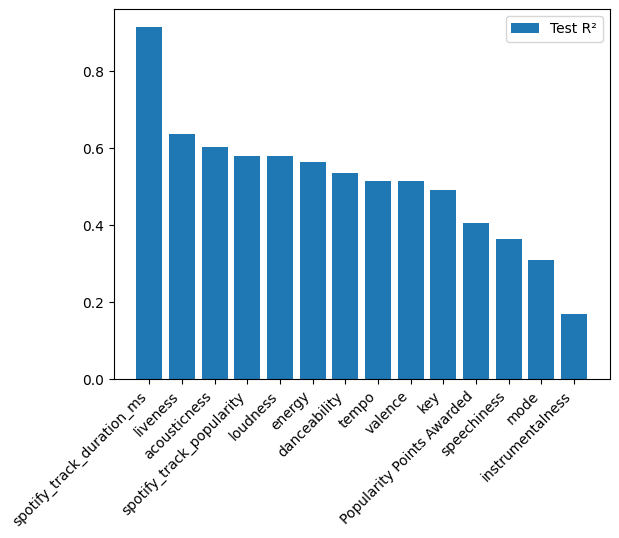

In [15]:
df_combined_lists = df_combined_lists.sort_values(by='Test R^2', ascending=False)
x = np.arange(len(df_combined_lists['Feature']))
plt.bar(x, df_combined_lists['Test R^2'], label='Test R²')
plt.xticks(x, df_combined_lists['Feature'], rotation=45, ha='right')
plt.legend()

From this, we can see by running regression with just one variable at a time, `spotify_track_duration_ms`, `liveness`, and `acousticness` had the highest R^2 scores. This leads us to believe that these are the most influential to determining if a song has love in it. Interestingly, `spotify_track_popularity`'s influence is higher than that of `Popularity Points Awarded`. 

### Random Forest to determine variable importance 
To compensate for what logistic regression may have missed, we also ran random forest on our dataset to see which variables best predicted whether songs had "love" in the title. Creating a regression for each variable individually may not make sense, as typically you would want multiple variables in a regression, so we decided to try random forest. 

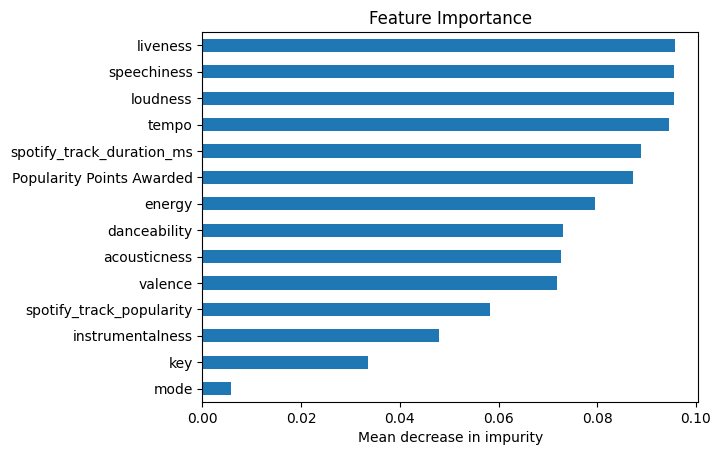

In [ ]:
#Trying random forest
from sklearn.ensemble import RandomForestRegressor

X = song_attribute_data.loc[:,['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',	'liveness',	'valence', 'tempo',	'spotify_track_popularity', 'Popularity Points Awarded']]
X = X.apply(minmax,axis=0)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=100)

model = RandomForestRegressor(max_depth=10, random_state=100) #Add random state for reproducibility 
rf = model.fit(X_train,y_train)

y_hat_rf = rf.predict(X_test)

#Create plot of feature importance 
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns )
feature_importances.sort_values().plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Mean decrease in impurity')
plt.show()

In [25]:
# looking at individual values 
pd.DataFrame(feature_importances).sort_values(by=0, ascending=False)

,0
liveness,0.095727
speechiness,0.095543
loudness,0.095493
tempo,0.094471
spotify_track_duration_ms,0.088944
Popularity Points Awarded,0.087150
energy,0.079595
danceability,0.072978
acousticness,0.072656
valence,0.071813


## Conclusion

In the end, our tests at regression returned some different variables than using random forest feature importance. They both had liveness in the top three. The individual regressions told us `spotify_track_duration`, `liveness`, and `acousticness` had the greatest influence, and that `instrumentalness` had the least influence. From our random forest we saw that `speechiness`, `liveness`, and `loudness` were the three most influential features, and that `instrumentalness` was also one of the least important. As the tests did share `liveness` as having a large influence, we may be able to predict the title of a track—and therefore its subject matter—from attributes of the songs. Different models, however, will lead us to different conclusions. 